## Codificadores Automáticos Empilhados com MNIST

## Importação do tensorflow


In [2]:
%pylab inline

from tensorflow import keras

Populating the interactive namespace from numpy and matplotlib


## Carregamento do conjuntos de dados
Para começar, será necessário carregar o conjunto de dados e separa-los entre aqueles que serão usado para treinamento e aqueles que serão usado para teste.

In [3]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255

11501568/11490434 [==============================] - 0s 0us/step


# 1º Parte - Contrução do modelo Dense para codificação e decodificação
Nesta primeira parte, começaremos criando modelos simples de Autoencoders e de forma separada. O objetivo é usa-los como entrada, e saida, em um novo Autoencoder Empilhado (Stacked Autoencoder) de forma a reduzir ainda mais o espaço latente adiquirindo as informações mais pertinentes.

A parte codificadora (encoder) e a parte decodificadora (decoder) serão modeladas usando duas camadas de redes convolucionais no entanto não serão treinandas ainda.

O treinamento de ambas acontecerá simultaneamente quando elas forem usadas no Autoencoder Empilhado.

In [4]:
encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(30, activation="relu"),
])

In [5]:
decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

#Análise do resumo do codificador e do decodificador
Analisando o sumário do codificador e do decodificador podemos notar que o modelo foi capaz de reduzir as dimensões do conjunto de dados de entrada para uma forma mais compacta e que o decodificador conseguiu restaurar as dimensões originais dos dados inseridos.

Enquanto o codificador conseguiu reduzir as dimensões que inicialmente eram de (28 x 28), o decodificador conseguiu aumentar a amostragens das imagens de volta para (28 x 28).

In [6]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
Total params: 81,530
Trainable params: 81,530
Non-trainable params: 0
_________________________________________________________________


In [7]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               3100      
                                                                 
 dense_3 (Dense)             (None, 784)               79184     
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 82,284
Trainable params: 82,284
Non-trainable params: 0
_________________________________________________________________


#Empilhamento de Autoencoders
Após a criação dos modelos simples de Autoencoders, pode-se então criar um modelo de Autoencoder utilizando ambos.

O modelo é então compilado usando o otimizador "adam" e as perdas são analisadas utilizando como parâmetro a função de entropia cruzada.

In [8]:
stacked_autoencoder = keras.models.Sequential([encoder, decoder])

stacked_autoencoder.compile(loss="binary_crossentropy",
                   optimizer='adam')

# Treinamento do modelo
O modelo é então treinado e validado, utilizando parte do conjunto de dados originais para o treinamento e parte para a validação.

In [9]:
history = stacked_autoencoder.fit(x_train, x_train, epochs=3,
                                  validation_data=(x_test, x_test))

Epoch 1/3
1875/1875 [==============================] - 9s 3ms/step - loss: 0.1417 - val_loss: 0.1053
Epoch 2/3
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1018 - val_loss: 0.0964
Epoch 3/3
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0961 - val_loss: 0.0931


# Reconstrução das imagens
Então, as imagens são reconstruidas para comparar a capacidade do modelo latente em reconstruir sua própria entrada.

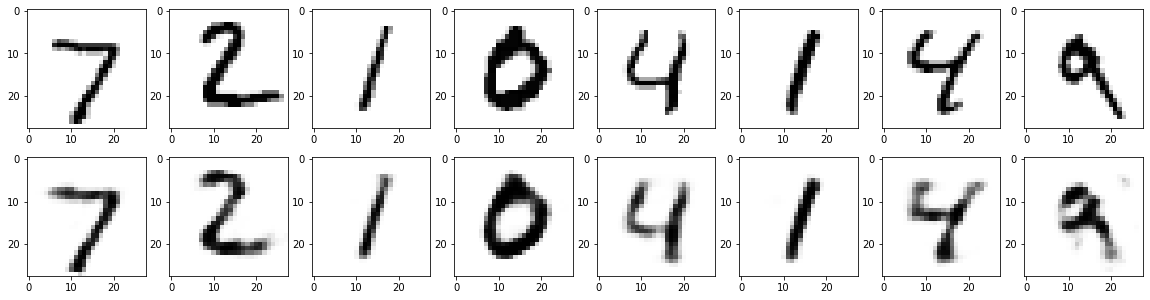

In [10]:
figsize(20, 5)
for i in range(8):
  subplot(2, 8, i+1)
  pred = stacked_autoencoder.predict(x_test[i].reshape((1, 28, 28)))
  imshow(x_test[i], cmap="binary")

  subplot(2, 8, i+8+1)
  imshow(pred.reshape((28, 28)), cmap="binary")

[[ 9.711021  12.643335  14.55455   14.65541    1.5509791 10.841675
  19.624214  14.881962  14.047782  13.453148   0.        13.039666
  19.66069    6.395769  17.16269    0.         8.165264   6.6068344
   6.1325755 12.507827   6.241631   8.779285  15.114032  15.92412
   8.529095  13.02555   12.872458  18.526175   0.         4.521504 ]]


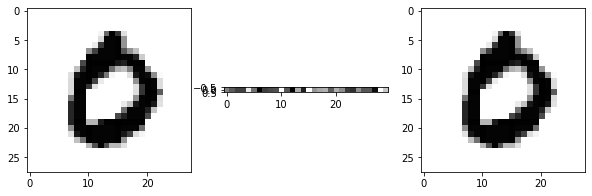

In [11]:
i = 3

figsize(10, 5)

subplot(1, 3, 1)
imshow(x_test[i], cmap="binary")

subplot(1, 3, 2)
latent_vector = encoder.predict(x_test[i].reshape((1, 28, 28)))
imshow(latent_vector, cmap="binary")
print(latent_vector)

subplot(1, 3, 3)
pred = decoder.predict(latent_vector)
imshow(x_test[i], cmap="binary")

In [12]:
30 / (28 * 28), 1 - 30 / (28 * 28)

(0.03826530612244898, 0.9617346938775511)

#Conclusão da primeira parte
Com o empilhamento dos Autoencoders foi possível reduzir as dimensões das imagens em 96%. Aconteceu a redução das dimensões de 28 x 28 (784) para apenas 30. Importante ressaltar que isso se deve pelo fato das imagens serem de baixa resolução. Dessa forma, quanto maior a resolução das imagens do conjunto de dados, menos compactadas elas poderão ser sem que ocorram grandes perdas de resolução em sua decodificação.

#2º Parte - Contrução do modelo Convolucional para codificação e decodificação
O modelo para esta segunda parte primeiramente é criado: serão usadas três camadas de redes convolucionais para a codificação e compactação do conjunto de dados e três camadas de redes deconvolucionais para decodificação com o objetivo de recriar o conjunto de dados.

O modelo é então compilado usando o otimizador "adam" e as perdas são analisadas utilizando como parâmetro a perda entropia cruzada.

```
# Isto está formatado como código
```



In [13]:
encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2)
])

In [14]:
decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=2, padding="valid",
                                 activation="relu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=(3, 3), strides=2, padding="same",
                                 activation="relu"),
    keras.layers.Conv2DTranspose(1, kernel_size=(3, 3), strides=2, padding="same",
                                 activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

In [15]:
stacked_autoencoder = keras.models.Sequential([encoder, decoder])

In [16]:
stacked_autoencoder.compile(loss="binary_crossentropy",
                            optimizer='adam')

# Treinamento do modelo
O modelo é então treinado e validado, utilizando parte do conjunto de dados para o treinamento e parte para a validação.

In [17]:
history = stacked_autoencoder.fit(x_train, x_train, epochs=10,
                         validation_data=[x_test, x_test])

Epoch 1/10
1875/1875 [==============================] - 17s 4ms/step - loss: 0.1212 - val_loss: 0.0839
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0809 - val_loss: 0.0771
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0765 - val_loss: 0.0746
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0739 - val_loss: 0.0724
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0724 - val_loss: 0.0709
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0713 - val_loss: 0.0707
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0706 - val_loss: 0.0695
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0700 - val_loss: 0.0691
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0696 - val_loss: 0.0690
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.06

# Reconstrução das imagens
Agora, as imagens são reconstruidas para se avaliar se o modelo foi capaz de reconstruir os dados inseridos por meio da utilização das redes neurais convolucionais.

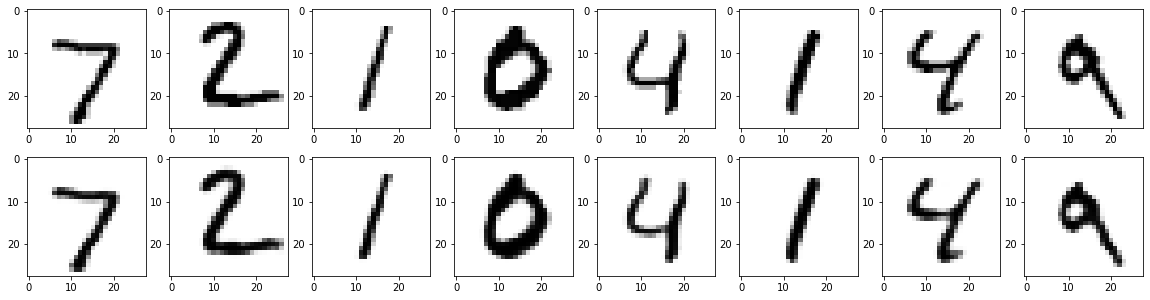

In [18]:
figsize(20, 5)
for i in range(8):
  subplot(2, 8, i+1)
  pred = stacked_autoencoder.predict(x_test[i].reshape((1, 28, 28)))
  imshow(x_test[i], cmap="binary")

  subplot(2, 8, i+8+1)
  imshow(pred.reshape((28, 28)), cmap="binary")

# Conclusão da segunda parte
A partir do uso das redes neurais convolucionais foi possível se treinar um modelo capaz de aprender os padrões de entrar e reconstuir com grande fidelidade os dados originais.

#3º Parte - Retirada de ruídos utilizando codificado automáticos
Para esta terceira parte, serão utilizadas redes neurais convolucionais como filtro para retirar ruídos das imagens. Para simular um possível ruido, serão adicionados aos conjunto de dados original um ruído com características randomicas.

O objetivo aqui é modelar uma rede que analisando o dado de saida esperado consiga aprender o que é ruido na imagem de entrada.



# Construção de imagem com ruído e comparação
Com o intuito de se ver as mudanças provocadas pela inserção desses ruídos artificais, faz se um esboço da imagem original e da nova.

In [21]:
import numpy as np

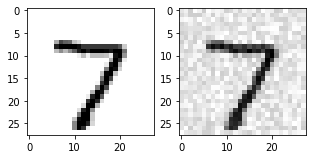

In [20]:
figsize(5, 10)
subplot(1, 2, 1)
imshow(x_test[0], cmap="binary")

subplot(1, 2, 2)
noise = np.random.random((28, 28)) / 4
imshow(x_test[0] + noise, cmap="binary")

#Contrução do modelo Convolucional para retirada de ruídos
Cria-se novamente e de forma separada o codificador e o decodificador utilizando redes Dense.

In [22]:
encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(30, activation="relu")
])

In [23]:
decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", input_shape=[30]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

#Empilhamento de Autoencoders
Após a criação dos modelos simples de Autoencoders, pode-se então criar um modelo de Autoencoder utilizando ambos.

O modelo é então compilado usando o otimizador "adam" e as perdas são analisadas utilizando como parâmetro a função de entropia cruzada.

In [24]:
stacked_autoencoder = keras.models.Sequential([encoder, decoder])

In [25]:
stacked_autoencoder.compile(loss="binary_crossentropy",
                            optimizer='adam')

#Inserção de ruídos no conjunto de dados
Para se testar o codificador automatico criado, serão inseridos no conjunto de dados ruídos para testar a capacidade do modelo em retira los.

In [26]:
x_train_noise = x_train + ((np.random.random(x_train.shape)) / 4)
x_test_noise = x_test + ((np.random.random(x_test.shape)) / 4)

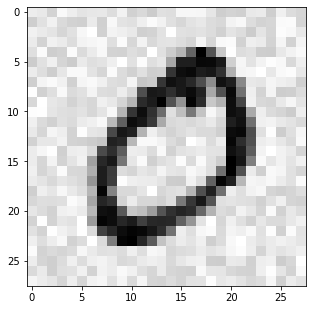

In [27]:
imshow(x_train_noise[1], cmap="binary")

# Treinamento do modelo
O modelo é então treinado e validado, utilizando parte do conjunto de dados com ruído para o treinamento e parte para a validação.

In [28]:
history = stacked_autoencoder.fit(x_train_noise, x_train, epochs=10,
                                  validation_data=(x_test_noise, x_test))

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1596 - val_loss: 0.1233
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1168 - val_loss: 0.1091
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1074 - val_loss: 0.1032
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1028 - val_loss: 0.1000
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0994 - val_loss: 0.0976
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0973 - val_loss: 0.0958
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0956 - val_loss: 0.0938
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0942 - val_loss: 0.0932
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0931 - val_loss: 0.0916
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.092

# Reconstrução das imagens
Agora, as imagens são reconstruidas para se avaliar se o modelo foi capaz de retirar os ruídos inseridos por meio da utilização das redes neurais convolucionais.

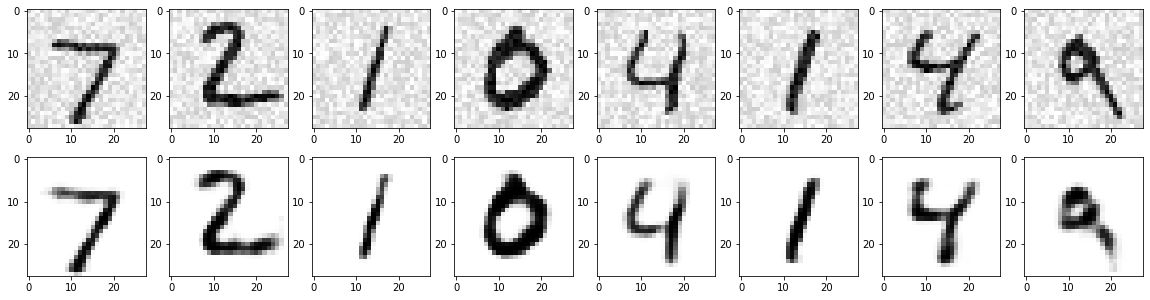

In [29]:
figsize(20, 5)
for i in range(8):
  subplot(2, 8, i+1)
  imshow(x_test_noise[i], cmap="binary")

  subplot(2, 8, i+8+1)
  pred = stacked_autoencoder.predict(x_test_noise[i].reshape((1, 28, 28)))
  imshow(pred.reshape((28, 28)), cmap="binary")

# Conclusão da terceira parte
A partir do uso das redes neurais convolucionais foi possível se treinar um modelo capaz de retirar os ruídos atribuidos inicialmente.